In [1]:
import base64
from io import BytesIO
import warnings
warnings.filterwarnings(action='ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem,  Draw, rdBase, rdCoordGen, rdDepictor
RDLogger.DisableLog('rdApp.error')
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D, SimilarityMaps
from rdkit.ML.Descriptors import MoleculeDescriptors
print(rdBase.rdkitVersion)
import seaborn as sns

RDKit WARNING: [22:55:40] Enabling RDKit 2019.09.1 jupyter extensions


2019.09.1


In [2]:
sns.set_style("whitegrid")

## Function Settings

In [3]:
# from chainer-chemistry's visualizer_utils.py
def red_blue_cmap(x):
    """Red to Blue color map
    Args:
        x (float): value between -1 ~ 1, represents normalized saliency score
    Returns (tuple): tuple of 3 float values representing R, G, B.
    """
    if x > 0:
        # Red for positive value
        # x=0 -> 1, 1, 1 (white)
        # x=1 -> 1, 0, 0 (red)
        return 1.0, 1.0 - x, 1.0 - x
    else:
        # Blue for negative value
        x *= -1
        return 1.0 - x, 1.0 - x, 1.0

def is_visible(begin, end):
    if begin <= 0 or end <= 0:
        return 0
    elif begin >= 1 or end >= 1:
        return 1
    else:
        return (begin + end) * 0.5
    
def color_bond(bond, saliency, color_fn):
    begin = saliency[bond.GetBeginAtomIdx()]
    end = saliency[bond.GetEndAtomIdx()]
    return color_fn(is_visible(begin, end))

In [4]:
def calc_crippen_weight(mol):
    contribs = Chem.rdMolDescriptors._CalcCrippenContribs(mol)
    weights = [x for x,y in contribs]
    return weights

In [5]:
def calc_tpsa_weight(mol):
    weights = Chem.rdMolDescriptors._CalcTPSAContribs(mol)
    return weights

In [6]:
def calc_gcharge_weight(mol):
    AllChem.ComputeGasteigerCharges(mol)
    weights = [float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) for i in range(mol.GetNumAtoms())]
    return weights

In [7]:
def moltopng(mol, atom_colors, bond_colors, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .2
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(atom_colors))], 
        highlightAtomColors=atom_colors, 
        highlightBonds=[i for i in range(len(bond_colors))],
        highlightBondColors=bond_colors,
        highlightAtomRadii={i: .5 for i in range(len(atom_colors))}
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

def label_cat(label):
    return '$+$' if bool(label!=0) else '$\cdot$'

In [8]:
# https://iwatobipen.wordpress.com/2017/02/25/draw-molecule-with-atom-index-in-rdkit/
def mol_with_atom_index(mol):
    import copy
    atoms = mol.GetNumAtoms()
    molwithidx = copy.deepcopy(mol)
    for idx in range( atoms ):
        molwithidx.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( molwithidx.GetAtomWithIdx( idx ).GetIdx() ) )
    return molwithidx

In [9]:
def draw_mols_with_idx(mol, atom_colors, bond_colors):
    images = []
    _img = moltopng(mol, atom_colors, bond_colors, molSize=(720, 480))
    output = BytesIO()
    output.write(_img)
    encoded_string = base64.b64encode(output.getvalue()).decode()
    images.append(f"<img style='width: 720px; margin: 0px; float: left; border: 0px solid black;' src='data:_img/png;base64,{encoded_string}' />")
    _img = moltopng(mol_with_atom_index(mol), {}, {}, molSize=(720, 470))
    output = BytesIO()
    output.write(_img)
    encoded_string = base64.b64encode(output.getvalue()).decode()
    images.append(f"<img style='width: 720px; margin: 0px; float: left; border: 0px solid black;' src='data:_img/png;base64,{encoded_string}' />")

    images = ''.join(images)
    display(HTML(images))

In [10]:
def plot_explainable_images(mol: rdkit.Chem.Mol, weight_fn, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br']):
    symbols = [f'{mol.GetAtomWithIdx(i).GetSymbol()}_{i}' for i in range(mol.GetNumAtoms())]
    df = pd.DataFrame(columns=atoms)
    contribs = weight_fn(mol)
    num_atoms = mol.GetNumAtoms()
    arr = np.zeros((num_atoms, len(atoms)))
    for i in range(mol.GetNumAtoms()):
        _a = mol.GetAtomWithIdx(i).GetSymbol()
        arr[i,atoms.index(_a)] = contribs[i]
    df = pd.DataFrame(arr, index=symbols, columns=atoms)
    weights, vmax = SimilarityMaps.GetStandardizedWeights(contribs)
    vmin = -vmax
    atom_colors = {i: red_blue_cmap(e) for i, e in enumerate(weights)}
    bondlist = [bond.GetIdx() for bond in mol.GetBonds()]
    bond_colors = {i: color_bond(bond, weights, red_blue_cmap) for i, bond in enumerate(mol.GetBonds())}

    draw_mols_with_idx(mol, atom_colors, bond_colors)
    
    fig = plt.figure(figsize=(18, 9))
    grid = plt.GridSpec(15, 10)
    ax = fig.add_subplot(grid[1:, -1])
    ax.barh(range(mol.GetNumAtoms()), np.maximum(0, df.values).sum(axis=1), color='C3')
    ax.barh(range(mol.GetNumAtoms()), np.minimum(0, df.values).sum(axis=1), color='C0')
    ax.set_yticks(range(mol.GetNumAtoms()))
    ax.set_ylim(-.5, mol.GetNumAtoms()-.5)
    ax.axvline(0, color='k', linestyle='-', linewidth=.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', left=False, labelleft=False)

    ax = fig.add_subplot(grid[1:, :-1], sharey=ax)
    im = ax.imshow(df.values, cmap='bwr', vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_yticks(range(mol.GetNumAtoms()))
    ax.set_ylim(mol.GetNumAtoms() -.5, -.5)
    symbols= {i: f'${mol.GetAtomWithIdx(i).GetSymbol()}_{{{i}}}$' for i in range(mol.GetNumAtoms())}
    ax.set_yticklabels(symbols.values())
    ax.set_xticks(range(len(atoms)))

    ax.set_xlim(-.5, len(atoms) -.5)
    ax.set_xticklabels(atoms, rotation=90)
    ax.set_ylabel('Node')

    for (j,i),label in np.ndenumerate(df.values):
        ax.text(i,j, label_cat(label) ,ha='center',va='center')
    ax.tick_params(axis='both', which='both', bottom=True, labelbottom=True, top=False, labeltop=False)
    ax.grid(b=None)


    ax = fig.add_subplot(grid[0, :-1])
    fig.colorbar(mappable=im, cax=ax, orientation='horizontal')
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False, top=True, labeltop=True)

    display(fig)
    plt.close(fig)

## Experiments

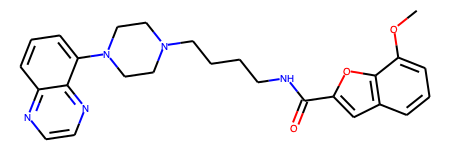

In [11]:
mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
mol

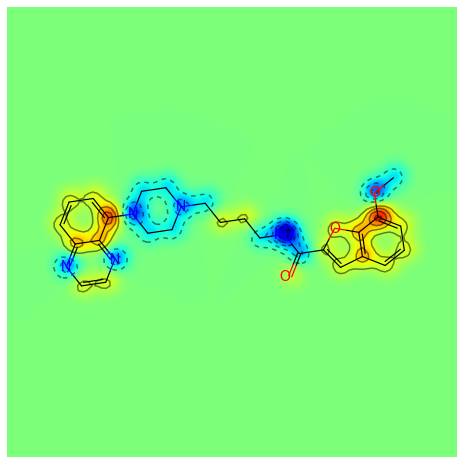

In [12]:
# https://www.rdkit.org/docs/GettingStartedInPython.html#visualization-of-descriptors
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, calc_crippen_weight(mol), colorMap='jet', contourLines=10)

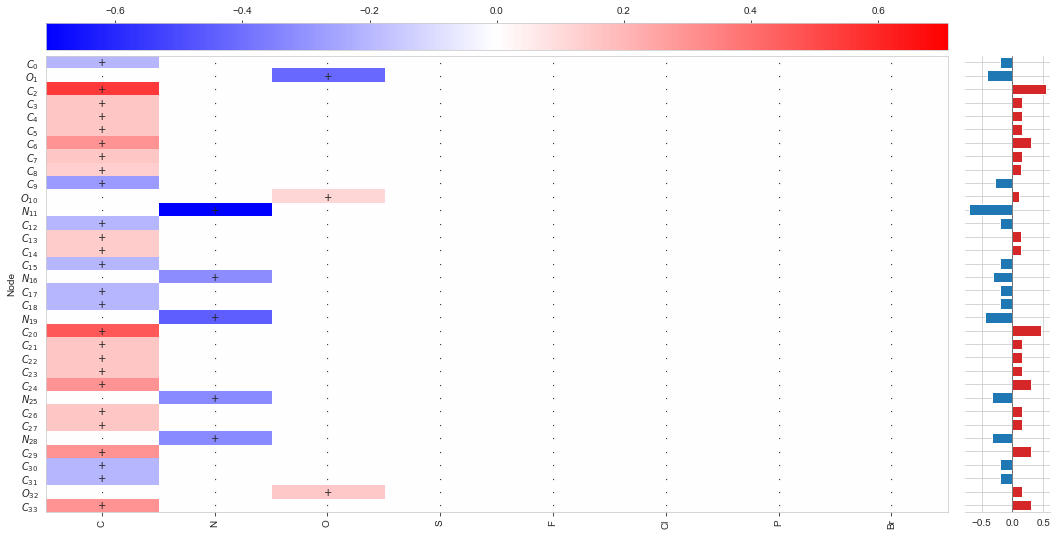

In [13]:
plot_explainable_images(mol, weight_fn=calc_crippen_weight, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])

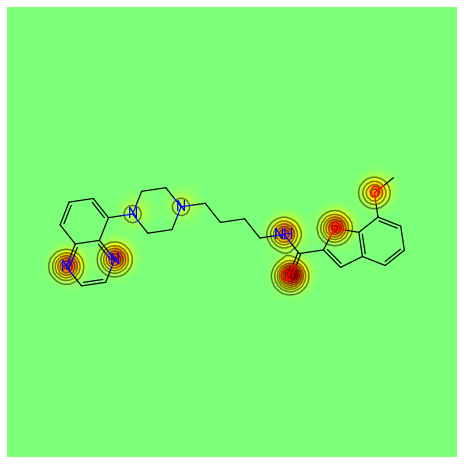

In [14]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, calc_tpsa_weight(mol), colorMap='jet', contourLines=10)

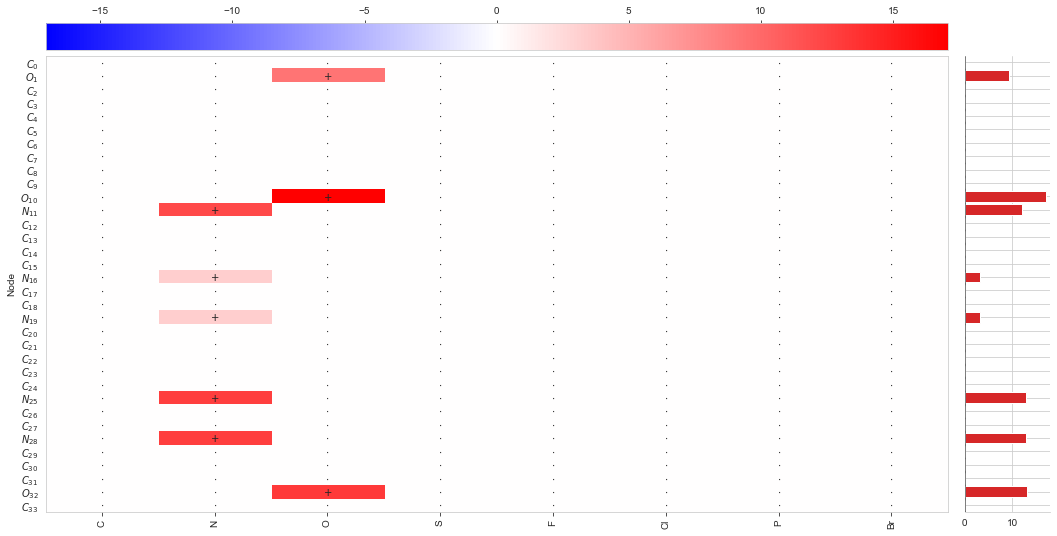

In [15]:
plot_explainable_images(mol, weight_fn=calc_tpsa_weight, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])

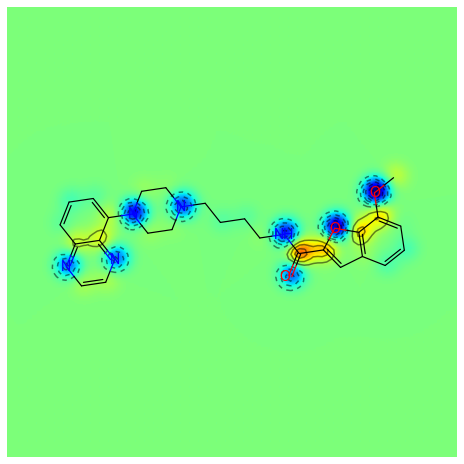

In [16]:
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, calc_gcharge_weight(mol), colorMap='jet', contourLines=10)

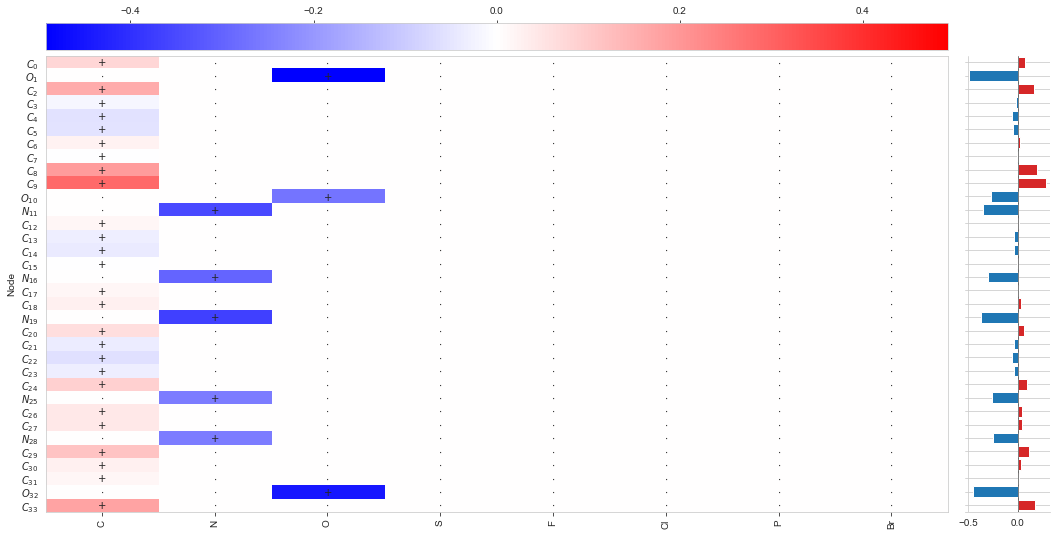

In [17]:
plot_explainable_images(mol, weight_fn=calc_gcharge_weight, atoms=['C', 'N', 'O', 'S', 'F', 'Cl', 'P', 'Br'])